supply and demand analysis
calculate changes in oil reserves, including the SPR, weekly and compared to last year
determine if changes are in line with expectations
if not in line with expectations determine if it is do to higher demand, lower production, more exports or a combination

In [1]:
import pandas as pd
import USA_oil_data as oil
import prices
from FRED_oil_data import get_fred_data
import matplotlib.pyplot as plt

In [2]:
weekly_stocks = oil.weekly_stocks()
spr = oil.spr_reserves()

In [3]:
merged = pd.merge(weekly_stocks, spr, on='period')
merged.sort_index(inplace=True)

In [4]:
ticks = [x for x in range(0, 1400000, 200000)]

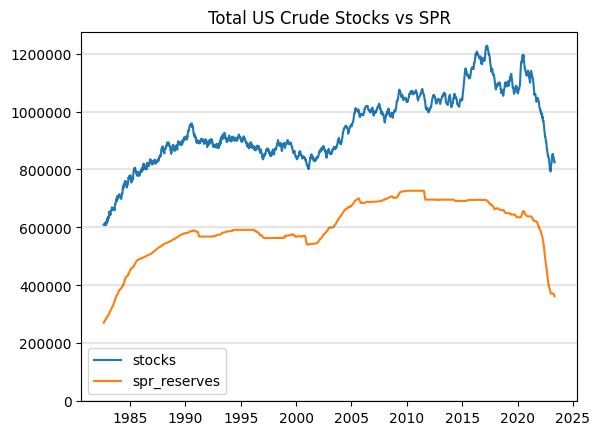

In [5]:
plt.plot(merged)

plt.yticks(ticks)
plt.ticklabel_format(axis='y', style='plain')
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.legend(merged.columns)
plt.title("Total US Crude Stocks vs SPR")
plt.show()

In [6]:
weekly_stocks = weekly_stocks.to_frame()

In [7]:
weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month
weekly_stocks = weekly_stocks[weekly_stocks['year'] > 2015]
monthly_average = weekly_stocks.groupby('month').mean()

In [8]:
grouped = weekly_stocks.groupby('year')

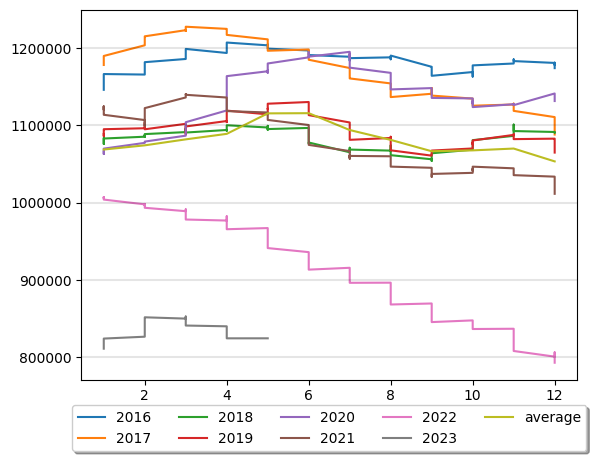

In [9]:
fig, ax = plt.subplots()

for name, group in grouped:
    ax.plot(group['month'], group['stocks'], label=name)
ax.plot(monthly_average.index, monthly_average['stocks'], label='average' )
plt.ticklabel_format(axis='y', style='plain')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#add horizontal lines
ticks = [x for x in range(800000, 1300000, 100000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)


plt.show()

In [10]:
weekly_stocks = oil.weekly_stocks()
weekly_stocks = weekly_stocks.to_frame()

weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month

weekly_stocks['diff'] = weekly_stocks['stocks'].diff(-1)
weekly_stocks = weekly_stocks[weekly_stocks['year'] >= 2018]

week_info = weekly_stocks.index.isocalendar()
week_number = week_info['week']

merged_df = pd.merge(week_number, weekly_stocks, left_index=True, right_index=True)

In [11]:
grouped = merged_df.groupby('year')

In [12]:
weeks = grouped['week'].unique()
years = len(grouped['year'].unique())
width = 0.8/years

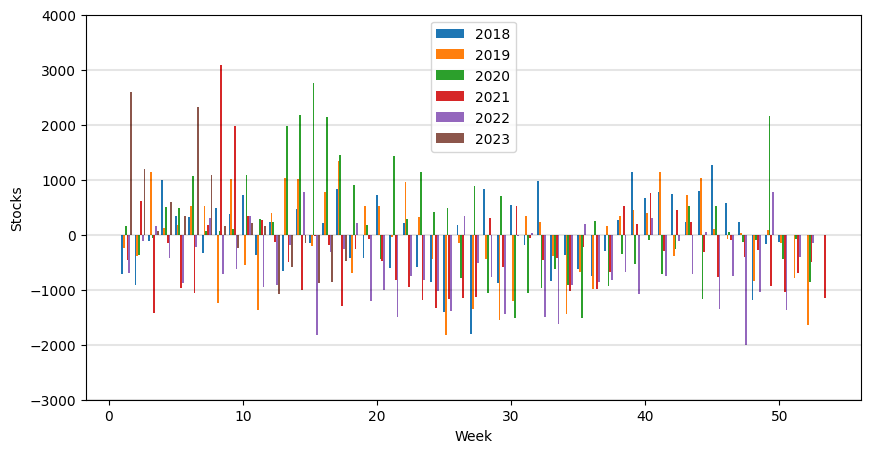

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
i = 0
for name, group in grouped:
    data = group[group['week'] < 53]
    data = group['diff']/7
    positions = group['week']


    ax.bar(positions + i * width, data, width=width, label=name)
    i += 1

ticks = [x for x in range(-3000, 4000, 1000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.ylim(-3000,4000)

ax.set_ylabel('Stocks')
ax.set_xlabel('Week')
ax.legend()

plt.show()

In [14]:
imports, exports = oil.imports_exports()

In [15]:
imports_exports = pd.merge(imports, exports, on='period')

imports_exports['year'] = imports_exports.index.year
imports_exports = imports_exports[imports_exports['year'] > 2005]

In [16]:
imports_exports['net'] = imports_exports['imports'] - imports_exports['exports']

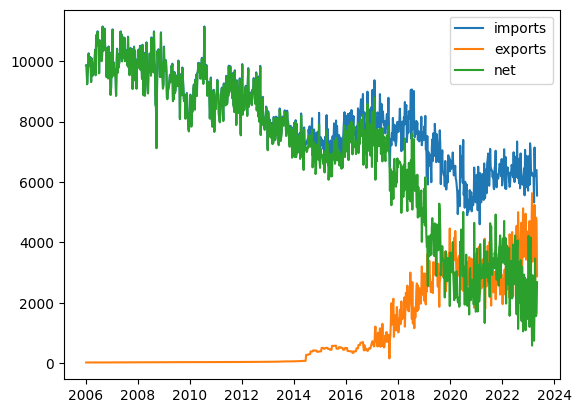

In [17]:
plt.plot(imports_exports[['imports', 'exports', 'net']])
plt.legend(imports_exports[['imports', 'exports', 'net']])

In [48]:
#supply data:

#production
production = oil.mbbl_production(years=20)

#reserves
reserves = oil.crude_oil_stocks()

#product supplied
product_supplied = oil.product_supplied()

#demand data:

#net exports
imports, exports = oil.imports_exports()
imports_exports = pd.merge(imports, exports, on='period')
imports_exports['net'] = imports_exports['exports'] - imports_exports['imports']
net_exports = imports_exports['net']




#sales (not updated since March 2022)
#gas_end_users = oil.gasoline_sales_end_user()
#gas_resale = oil.gasoline_sales_resale()


In [49]:
net_exports = net_exports.resample('M').sum()
net_exports.index = net_exports.index - pd.offsets.MonthBegin(1)

In [51]:
#merge all data into one dataframe
supply_demand = pd.merge(production, reserves, on='period')
supply_demand = pd.merge(supply_demand, product_supplied, on='period')
supply_demand = pd.merge(supply_demand, net_exports, on='period')


In [56]:
changes = supply_demand.diff(12)

In [59]:
changes = changes[changes.index > '2018-12-01']

<AxesSubplot:xlabel='period'>

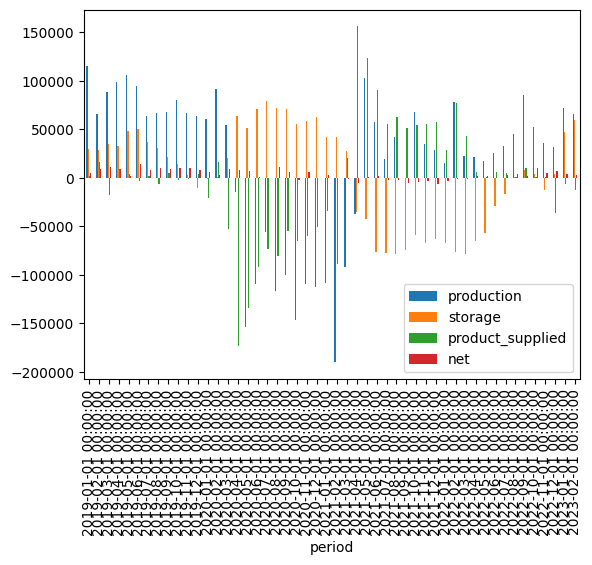

In [61]:
changes.plot.bar()